In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.pipeline import Pipeline
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

In [2]:
## Read CSV files
books = pd.read_csv('../../data/books.csv')
ratings = pd.read_csv('../../data/ratings.csv')
tags = pd.read_csv('../../data/tags.csv')
book_tags = pd.read_csv('../../data/book_tags.csv')

In [3]:
pd.set_option('display.max_columns', None)
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
books2 = books.drop(columns=['best_book_id','work_id','books_count','isbn','isbn13','original_publication_year','original_title','language_code','average_rating','ratings_count','work_text_reviews_count','work_ratings_count','ratings_1','ratings_2','ratings_3','ratings_4','ratings_5','image_url','small_image_url'])

In [5]:
books2.head()

,book_id,goodreads_book_id,authors,title
0,1,2767052,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,41865,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,2657,Harper Lee,To Kill a Mockingbird
4,5,4671,F. Scott Fitzgerald,The Great Gatsby


In [6]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [7]:
ratings2 = pd.merge(ratings,books2,on='book_id',how='left')
ratings2 = ratings2.drop(columns=['book_id','authors'])

In [8]:
ratings2.head()

,user_id,rating,goodreads_book_id,title
0,1,5,1232,The Shadow of the Wind (The Cemetery of Forgot...
1,2,4,231,I am Charlotte Simmons
2,2,5,4865,How to Win Friends and Influence People
3,2,5,4887,The Drama of the Gifted Child: The Search for ...
4,2,3,998,The Millionaire Next Door: The Surprising Secr...


In [9]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [10]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [11]:
# Merge tags and book_tags
book_tags = pd.merge(book_tags,tags,on='tag_id',how='left')

In [12]:
book_tags.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult


In [13]:
# Function that convert book_id to title
def convert_book_id_to_title(goodreads_book_id):
    title = ratings_with_titles[ratings_with_titles['book_id'] == goodreads_book_id]['title'].iloc[0]
    return title if not pd.isnull(title) else f'Unknown Title for book_id: {goodreads_book_id}'

In [14]:
# Split to test set and train set
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings2, test_size=0.2)

In [15]:
### Get most popular books ###

# Count number of ratings
count_ratings = pd.DataFrame(ratings2[['goodreads_book_id', 'rating']].groupby('goodreads_book_id').count().reset_index())
count_ratings.columns = ['goodreads_book_id', 'n_ratings']

# Get average ratings
average_ratings = pd.DataFrame(ratings2[['goodreads_book_id', 'rating']].groupby('goodreads_book_id').mean().reset_index())
average_ratings.columns = ['goodreads_book_id', 'avg_rating']

# Merge them
book_pop = pd.merge(count_ratings, average_ratings,on='goodreads_book_id',how='left')

# Exclude rows that average ratings are less than 4.0
book_pop = book_pop.query("avg_rating > 4.0")

# Add book titles
books_pop_title = pd.merge(book_pop, ratings2[['goodreads_book_id', 'title']], how='left')

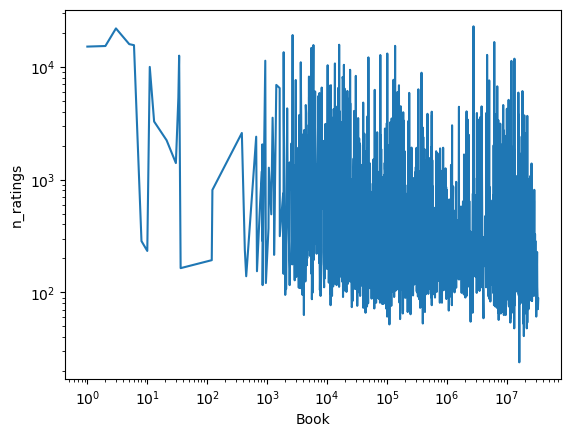

In [16]:
# Visualize the number of ratings
plt.plot(book_pop['goodreads_book_id'], book_pop['n_ratings'])
plt.xlabel('Book')
plt.ylabel('n_ratings')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [17]:
# Get 10 most popular books
book_pop.sort_values(by=['n_ratings','avg_rating'], ascending=False).head(10)

,goodreads_book_id,n_ratings,avg_rating
6193,2767052,22806,4.279707
2,3,21850,4.351350
198,2657,19088,4.329369
6594,6148028,16549,4.133422
3,5,15855,4.418732
1276,15881,15657,4.229418
507,5907,15558,4.148477
4,6,15523,4.430780
3890,136251,15304,4.525941
1,2,15258,4.358697


In [18]:
# Calculate MSE for 10 most popular books

# Create a DataFrame with the most popular books (books with high average ratings)
popular_books = book_pop.sort_values(by=['n_ratings', 'avg_rating'], ascending=False).head(10)

# Merge the test data with the popular books to get the actual ratings for the popular books
actual_ratings_popular_books = pd.merge(test, popular_books[['goodreads_book_id']], how='inner', on='goodreads_book_id')

# Filter the actual ratings to include only the popular books
actual_ratings_popular_books = actual_ratings_popular_books[actual_ratings_popular_books['goodreads_book_id'].isin(ratings2['goodreads_book_id'])]

# Calculate MSE for the recommended popular books
mse_popular_books = mean_squared_error(actual_ratings_popular_books['rating'], [5] * len(actual_ratings_popular_books))

print(f'Mean Squared Error (MSE) for Recommended Popular Books: {mse_popular_books:.2f}')

Mean Squared Error (MSE) for Recommended Popular Books: 1.19


In [19]:
### Cosine Similarity ###

# build user- item matrix
user_item_matrix = ratings2.pivot_table(index='user_id', columns='goodreads_book_id', values='rating', fill_value=0)

# Convert the DataFrame to a NumPy array
user_item_matrix = user_item_matrix.values
print("User-Item Matrix:")
print(user_item_matrix)

User-Item Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 5. 5. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]]


In [20]:
### Collaborative filtering using KNN ###
from surprise.model_selection import GridSearchCV
from surprise import AlgoBase
from surprise import dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from __future__ import (absolute_import, division, print_function, unicode_literals)
from surprise.model_selection import train_test_split
import os 
from surprise import BaselineOnly, Dataset, Reader
from surprise import KNNBasic

# Convert Dataframe to Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings2[['user_id', 'goodreads_book_id', 'rating']], reader)

# Split the data into training and testing sets
train_surprise, test_surprise = train_test_split(data, test_size = 0.2)

In [21]:
# Build and train the KNN model
sim_options = {'name': 'cosine', 'user_based': False}
knn_model = KNNBasic(sim_options=sim_options)
knn_model.fit(train_surprise)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
# Recommend books for a specific user
user_id = 2
user_books = [book_id for book_id, _ in train_surprise.ur[train_surprise.to_inner_uid(user_id)]]
unrated_books = list(set(train_surprise.all_items()) - set(user_books))

# Get top N book recommendations for the user
N = 10
book_recommendations = [(book_id, knn_model.predict(user_id, book_id).est) for book_id in unrated_books]
sorted_recommendations = sorted(book_recommendations, key=lambda x: x[1], reverse=True)[:N]

# Display the top N recommendations
for book_id, predicted_rating in sorted_recommendations:
    print(f"Book ID: {book_id}")

Book ID: 3869
Book ID: 4929
Book ID: 4406
Book ID: 5064
Book ID: 9820
Book ID: 4898
Book ID: 2615
Book ID: 6150
Book ID: 6656
Book ID: 11


In [23]:
# Make predictions on the test set
predictions = knn_model.test(test_surprise)

# Extract actual ratings and predicted ratings
actual_ratings_surprise = [rating for _, _, rating in test_surprise]
predicted_ratings_surprise = [prediction.est for prediction in predictions]

# Evaluate the model
mse_knn = mean_squared_error(actual_ratings_surprise, predicted_ratings_surprise)

print(f'Mean Squared Error (MSE) for KNN model: {mse_knn}')

Mean Squared Error (MSE) for KNN model: 0.7799134321248751


In [24]:
### Matrix Factorization ###
class MF(AlgoBase):
    def __init__(self, learning_rate, num_epochs, num_factors):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_factors = num_factors

    def fit(self, train):
        n_users = train.n_users
        n_items = train.n_items
        self.trainset=train
        # Initialize user and item matrices with random values
        self.P = np.random.rand(n_users, self.num_factors)
        self.Q = np.random.rand(n_items, self.num_factors)

        for _ in range(self.num_epochs):
            for u, i, r in train.all_ratings():
                error = r - np.dot(self.P[u], self.Q[i])
                self.P[u] += self.learning_rate * (error * self.Q[i])
                self.Q[i] += self.learning_rate * (error * self.P[u])

    def estimate(self, u, i):
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return np.dot(self.P[u], self.Q[i])
        else:
            return 0
        
# Create an instance of MF and fit 
mf_model = MF(learning_rate=0.01, num_epochs=10, num_factors=20)
mf_model.fit(train_surprise)

In [25]:
# Choose a user for whom you want to get book recommendations
user_id_to_recommend = 2 

# Get the raw user ID for the chosen user in the train set
raw_user_id = user_id_to_recommend

# Predict ratings for all items not rated by the user
inner_user_id = mf_model.trainset.to_inner_uid(raw_user_id)
predictions = [mf_model.predict(inner_user_id, i).est for i in range(mf_model.trainset.n_items) if not mf_model.trainset.ur[inner_user_id] or i not in mf_model.trainset.ur[inner_user_id]]

# Get the indices of the top N recommended items
N = 10
recommended_item_indices = np.argsort(predictions)[-N:][::-1]

# Display the recommended item indices
print("Recommended Items", recommended_item_indices)

Recommended Items [6751 6748  291 2677   10 7805 6150 3291 5096 4591]


In [26]:
# MSE
preds = [mf_model.estimate(uid, iid) for uid, iid, _ in test_surprise]
mse_mf = mean_squared_error(actual_ratings_surprise, preds)

In [27]:
print(f'Mean Squared Error (MSE) for Matrix Factorization model: {mse_mf}')

Mean Squared Error (MSE) for Matrix Factorization model: 13.21393171761561


In [87]:
## Hybrid model of KNN and Matrix Factorization
class HybridMF: 
    def __init__(self, knn, mf):
        self.knn = knn
        self.mf = mf
        self.hybrid_pred = []
        
    def fit(self, train):
        self.knn.fit(train)
        self.mf.fit(train)
        
    def test(self, test):
        
        for u, i, r in test:
            pred1 = self.mf.estimate(u,i)
            predKNN = self.knn.predict(u, i)
            pred2 = predKNN.est
            self.hybrid_pred.append((pred1 + pred2) /2)
            
    def recommend(self, user_id, train, num_recommendations=10):
        # Get all items not interacted by the user
        non_interacted_items = [i for i in train.all_items() if not train.ur[user_id]]

        # Sort non-interacted items by predicted ratings in descending order
        sorted_items = sorted(non_interacted_items, key=lambda item: self.hybrid_pred[item], reverse=True)

        # Return top N recommended book_ids
        recommendations = sorted_items[:num_recommendations]
        return recommendations
        
    
    def calculate_mse(self, test):
        squared_errors = []
        count = 0
        for u, i, r in test:
            squared_errors.append((r - self.hybrid_pred[count]) ** 2)
            count += 1
            if count == len(self.hybrid_pred):
                break
        mse = sum(squared_errors) / len(self.hybrid_pred)
        return mse

# Create the hybrid recommender system
hybrid_recommender = HybridMF(knn_model, mf_model)
hybrid_recommender.fit(train_surprise)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [88]:
user_id = 2
hybrid_recommender.test(test_surprise)
hybrid_recommendations = hybrid_recommender.recommend(user_id, train_surprise, 10)
print(f'Hybrid Recommendations for User {user_id}: {hybrid_recommendations}')

Hybrid Recommendations for User 2: []


In [92]:
mse_hybrid = hybrid_recommender.calculate_mse(test_surprise)
print(f'Mean Squared Error (MSE) for Hybrid Recommender: {mse}')

Mean Squared Error (MSE) for Hybrid Recommender: 3.7666389112680365


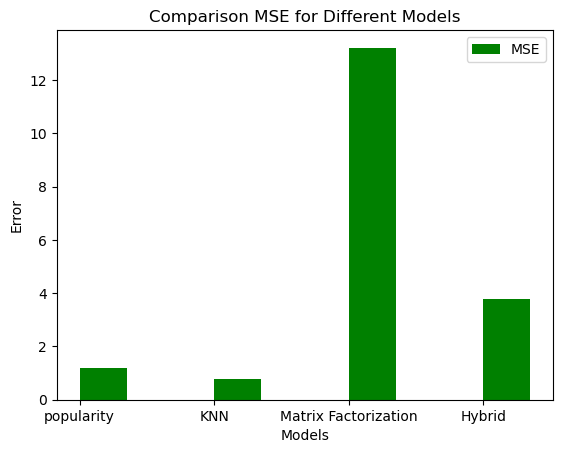

In [94]:
# Placeholder values for model results
models = ['popularity', 'KNN', 'Matrix Factorization', 'Hybrid']
mse_values = [mse_popular_books, mse_knn, mse_mf, mse_hybrid]   

# Plotting the bar graph
bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots()
bar = ax.bar([i + bar_width for i in index], mse_values, bar_width, label='MSE', color='g')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Error')
ax.set_title('Comparison MSE for Different Models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()